In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import re
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack


In [2]:
cols=['id','text','sentiment','intensity']
train_data=pd.read_csv('train_tot.txt',sep='\t',header=None,names=cols)
#test_data=pd.read_csv('test2.txt',sep='\t',header=None,names=cols)

In [3]:
train_data.head()


#data_text =pd.read_csv("train_anger.txt",sep="\n",engine="python",skiprows=1)

,id,text,sentiment,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [4]:
#test_data.head()

In [5]:
train_data.drop_duplicates()

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11047 entries, 0 to 11046
Data columns (total 4 columns):
id           11047 non-null int64
text         11047 non-null object
sentiment    11047 non-null object
intensity    11047 non-null object
dtypes: int64(1), object(3)
memory usage: 345.3+ KB


In [6]:
#test_data.drop_duplicates()

#test_data.info()

In [7]:

train_data.describe()

,id
count,11047.000000
mean,25194.730062
std,10635.896422
min,10000.000000
25%,20132.500000
50%,21911.000000
75%,31411.500000
max,41532.000000


In [8]:
train_data.shape

(11047, 4)

In [9]:
train_data.drop(['id'],axis=1,inplace=True)

In [10]:
train_data.head()

,text,sentiment,intensity
0,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,So my Indian Uber driver just called someone t...,anger,0.896
2,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,Don't join @BTCare they put the phone down on ...,anger,0.896


In [11]:
train_data['sentiment'].replace(['anger','fear','sadness','joy'],[0,1,2,3],inplace=True)

In [12]:
train_data.head()

,text,sentiment,intensity
0,How the fu*k! Who the heck! moved my fridge!.....,0,0.938
1,So my Indian Uber driver just called someone t...,0,0.896
2,@DPD_UK I asked for my parcel to be delivered ...,0,0.896
3,so ef whichever butt wipe pulled the fire alar...,0,0.896
4,Don't join @BTCare they put the phone down on ...,0,0.896


In [13]:
train_data['pre_clean_len']=[len(t) for t in train_data.text]

In [14]:
train_data.head()

,text,sentiment,intensity,pre_clean_len
0,How the fu*k! Who the heck! moved my fridge!.....,0,0.938,96
1,So my Indian Uber driver just called someone t...,0,0.896,120
2,@DPD_UK I asked for my parcel to be delivered ...,0,0.896,108
3,so ef whichever butt wipe pulled the fire alar...,0,0.896,134
4,Don't join @BTCare they put the phone down on ...,0,0.896,125


In [15]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':train_data.sentiment.dtype,
        'description':'sentiment class - 0:anger, 1:fear,2:sadness,3:joy'
    },
    'text':{
        'type':train_data.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':train_data.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':train_data.shape
}

In [16]:
pprint(data_dict)

{'dataset_shape': (11047, 4),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:anger, '
                              '1:fear,2:sadness,3:joy',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


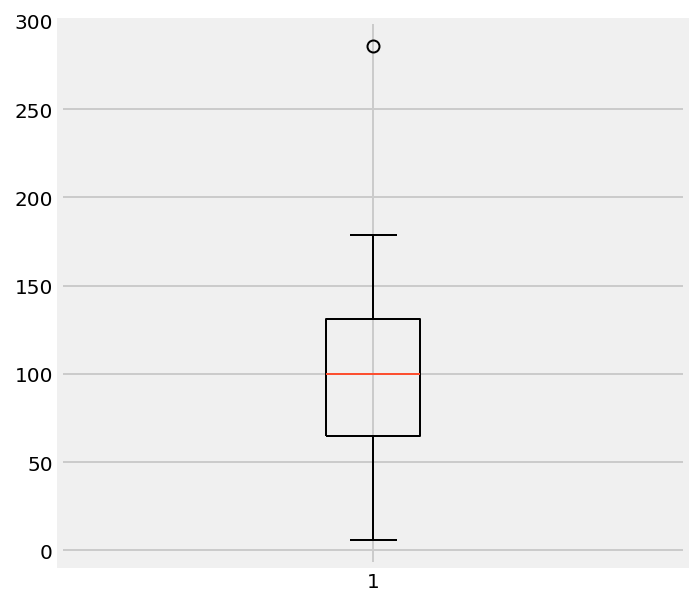

In [17]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(train_data.pre_clean_len)
plt.show()

In [18]:
train_data['index']=train_data['text'].str.find('&amp')
train_data[train_data['text'].str.find('&amp')!=-1]

,text,sentiment,intensity,pre_clean_len,index
46,Some Mexican ladies irritate the fuck outta me...,0,0.771,129,111
136,@gerfingerpoken #rage?? The #CrookedCourt said...,0,0.667,141,121
171,@snowangel415 @cjwalters66 Maybe also being at...,0,0.646,144,84
176,the girl sitting in front of me is chewing her...,0,0.646,89,62
214,"People need a way to escape,escape what?This c...",0,0.604,143,112
240,@UnitedFrontRev @JuanDeznuts @LucidHurricane_ ...,0,0.629,135,105
251,"If you be #angry, which may be the case, &amp;...",0,0.583,138,41
259,@saclivin @MrsCagg specific &amp; intentional ...,0,0.583,143,28
269,Did we miss the fact that #BurkeRamsey swung &...,0,0.598,138,45
298,Candace &amp; her pout are getting right on my...,0,0.562,57,8


In [19]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()


In [20]:
%%time
print("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(train_data)):
    if( (i+1)%1000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, len(train_data) ))                                                                    
    clean_tweet_texts.append(tweet_cleaner_updated(train_data['text'][i]))


Cleaning the tweets...

Tweets 1000 of 11047 has been processed
Tweets 2000 of 11047 has been processed
Tweets 3000 of 11047 has been processed
Tweets 4000 of 11047 has been processed
Tweets 5000 of 11047 has been processed
Tweets 6000 of 11047 has been processed
Tweets 7000 of 11047 has been processed
Tweets 8000 of 11047 has been processed
Tweets 9000 of 11047 has been processed
Tweets 10000 of 11047 has been processed
Tweets 11000 of 11047 has been processed
CPU times: user 2.65 s, sys: 19.3 ms, total: 2.67 s
Wall time: 2.65 s


In [21]:
clean_tweet_texts[46]

'some mexican ladies irritate the fuck outta me have their own lil preschool of fucking kids for the welfare allllat smh'

In [22]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = train_data.sentiment
clean_df.head()

,text,target
0,how the fu who the heck moved my fridge should...,0
1,so my indian uber driver just called someone t...,0
2,asked for my parcel to be delivered to pick up...,0
3,so ef whichever butt wipe pulled the fire alar...,0
4,do not join they put the phone down on you tal...,0


In [23]:
clean_df.shape

(11047, 2)

In [24]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [25]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,how the fu who the heck moved my fridge should...,0
1,so my indian uber driver just called someone t...,0
2,asked for my parcel to be delivered to pick up...,0
3,so ef whichever butt wipe pulled the fire alar...,0
4,do not join they put the phone down on you tal...,0


In [26]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11047 entries, 0 to 11046
Data columns (total 2 columns):
text      11047 non-null object
target    11047 non-null int64
dtypes: int64(1), object(1)
memory usage: 258.9+ KB


In [27]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target


In [28]:
np.sum(my_df.isnull().any(axis=1))

0

In [29]:
my_df.isnull().any(axis=0)

text      False
target    False
dtype: bool

In [30]:
anger_tweets = my_df[my_df.target == 0]
anger_string = []
for t in anger_tweets.text:
    anger_string.append(t)
anger_string = pd.Series(anger_string).str.cat(sep=' ')

In [31]:
conda install -c conda-forge wordcloud

Solving environment: done

## Package Plan ##

  environment location: /home/piyush/anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.8.2                |           py37_0         3.0 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates      anaconda::ca-certificates-2020.1.1-0 --> conda-forge::ca-certificates-2019.11.28-hecc5488_0
  certifi                                          anaconda --> conda-forge
  conda                                            anaconda --> conda-forge
  openssl                anaconda::openssl-1.1.1-h7b6447c_0 --> conda-forge::openssl-1.1.1d

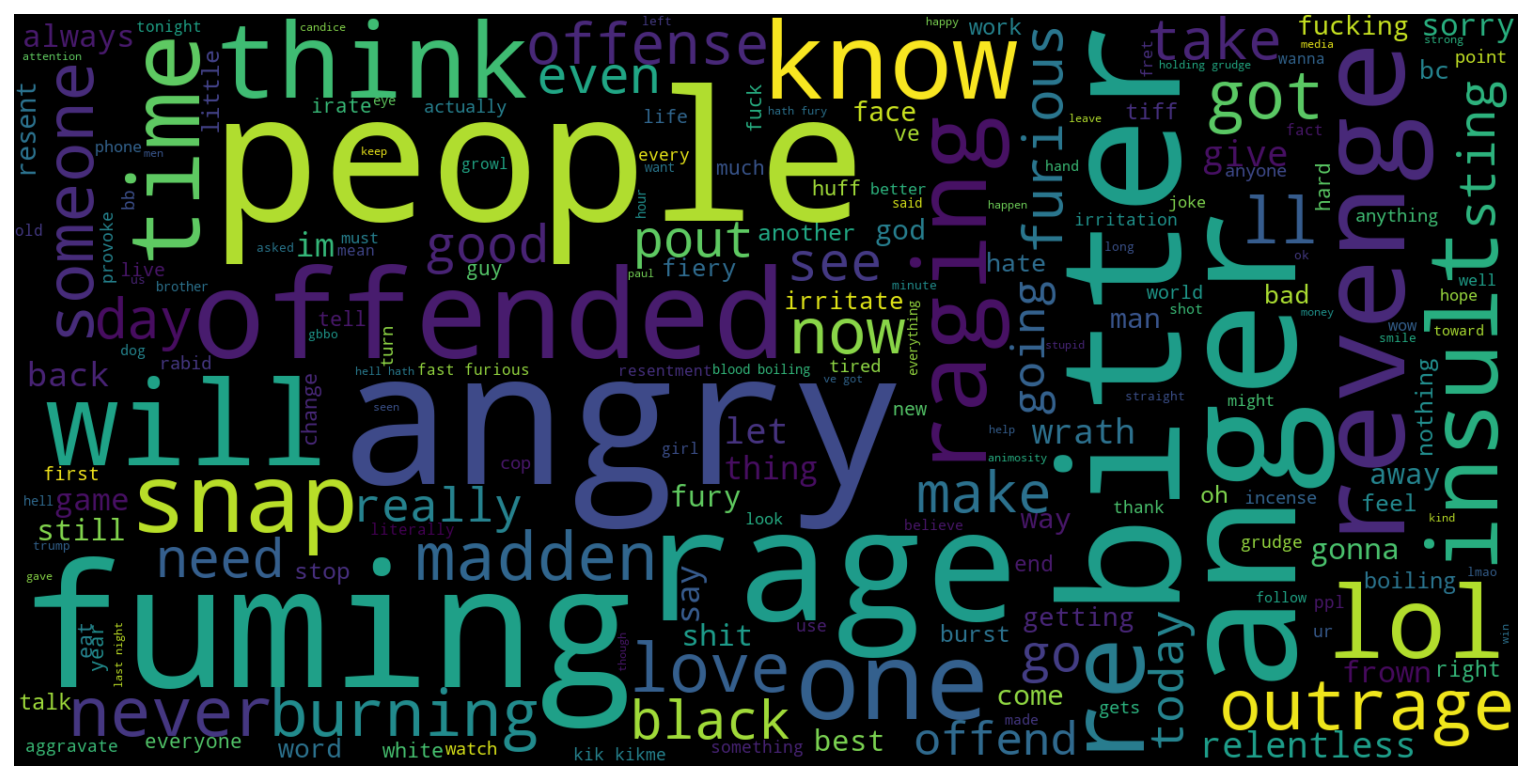

In [32]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [33]:
for t in anger_tweets.text[:200]:
    if 'love' in t:
        print(t)

just love it when people make plans for me without actually including me in this process rage


In [34]:
fear_tweets = my_df[my_df.target == 1]
fear_string = []
for t in fear_tweets.text:
    fear_string.append(t)
fear_string = pd.Series(fear_string).str.cat(sep=' ')

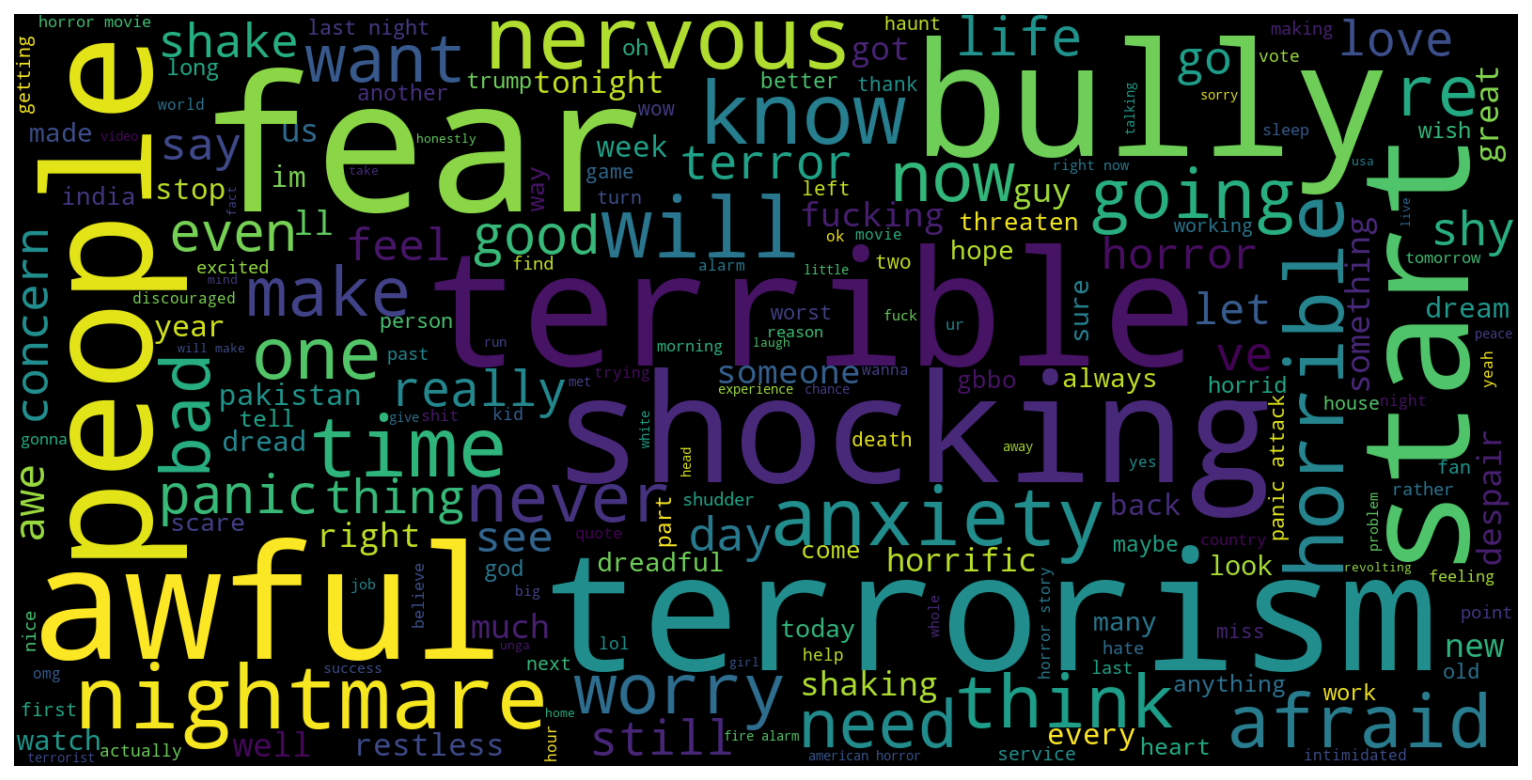

In [35]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(fear_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [36]:
sad_tweets = my_df[my_df.target == 2]
sad_string = []
for t in sad_tweets.text:
    sad_string.append(t)
sad_string = pd.Series(sad_string).str.cat(sep=' ')

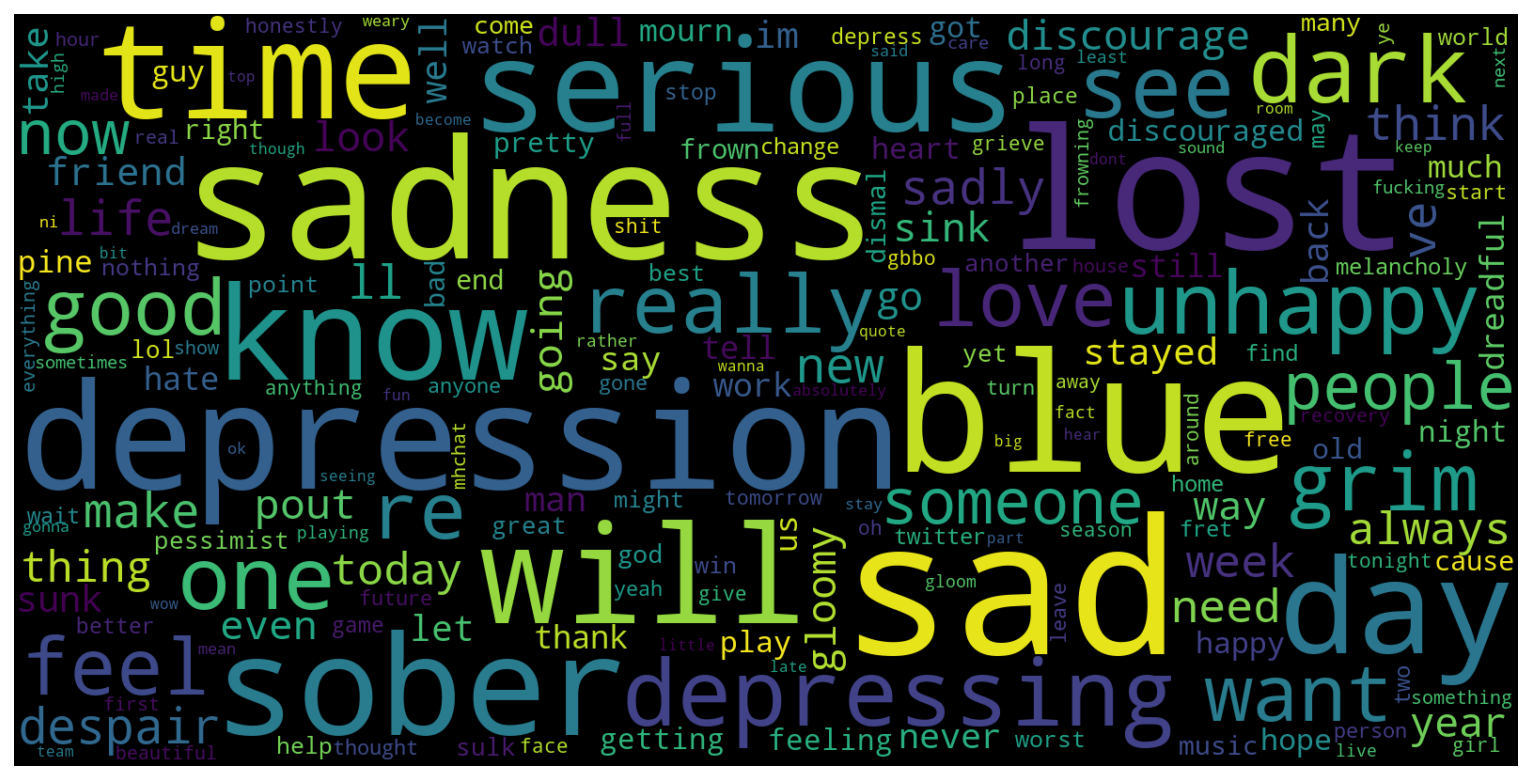

In [37]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(sad_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [38]:
joy_tweets = my_df[my_df.target == 3]
joy_string = []
for t in joy_tweets.text:
    joy_string.append(t)
joy_string = pd.Series(joy_string).str.cat(sep=' ')

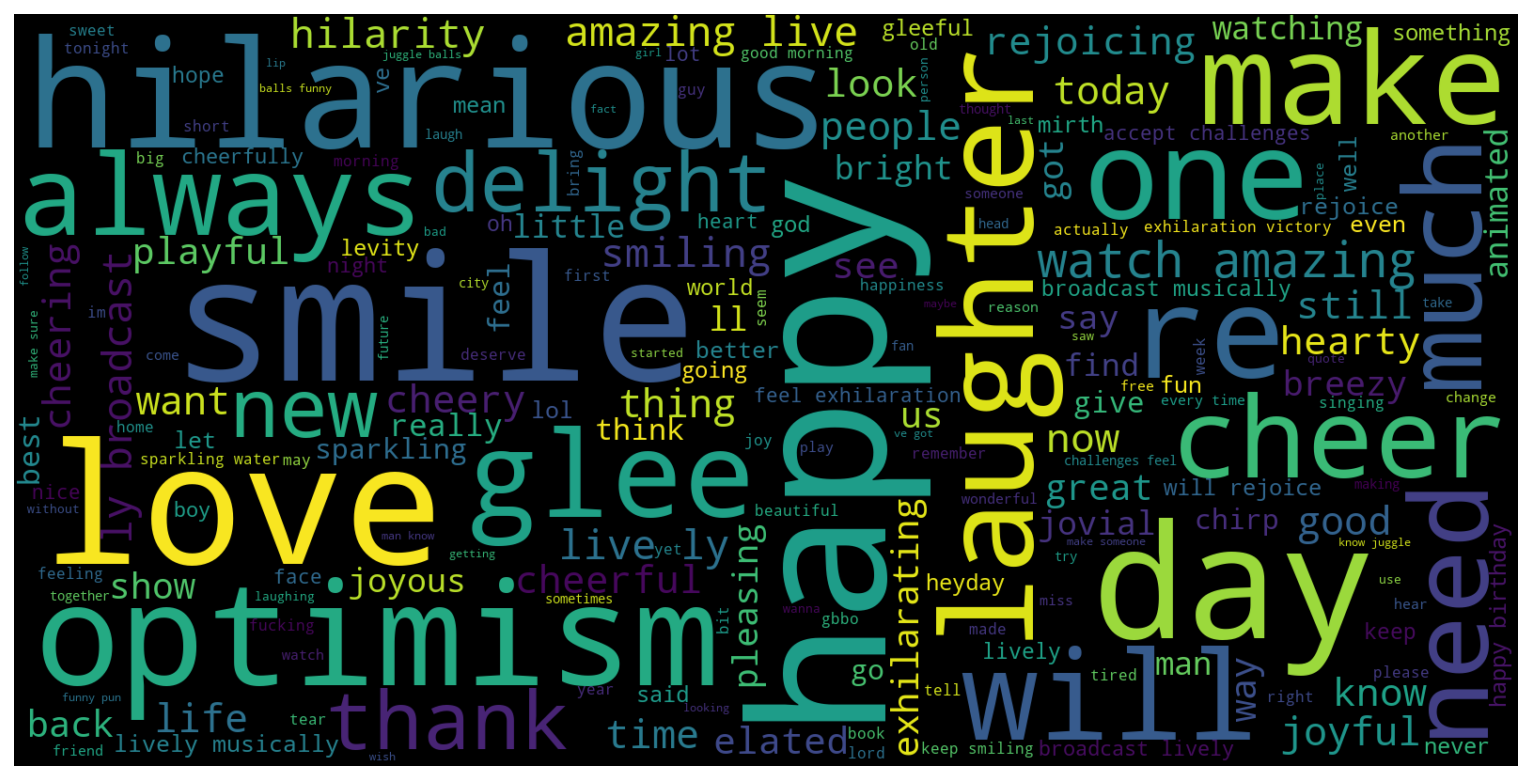

In [39]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(joy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [40]:
del joy_tweets, joy_string, anger_tweets, anger_string,fear_tweets, fear_string, sad_tweets, sad_string, wordcloud

In order for me to implement a couple of data visualisation in the next step, I need term frequency data.
What kind of words are used in the tweets, and how many times it is used in entire corpus.
I used count vectorizer to calculate the term frequencies, the count vectorizer is also for fit, train and predict,
but at this stage, I will just be extracting the term frequencies for the visualisation.

There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms.
However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [42]:
#len(cvec.get_feature_names())
cvec.get_feature_names()

['aa',
 'aaa',
 'aaaaarrrrgghhh',
 'aaahhhh',
 'aameen',
 'aaron',
 'aarp',
 'aateam',
 'ab',
 'abby',
 'abc',
 'aber',
 'aberdeen',
 'abhijit',
 'abhors',
 'ability',
 'abla',
 'able',
 'aboard',
 'abomination',
 'abood',
 'abortion',
 'abounds',
 'about',
 'aboutsin',
 'above',
 'abraham',
 'abroad',
 'abs',
 'abscess',
 'absence',
 'absolute',
 'absolutely',
 'absurd',
 'abt',
 'abundance',
 'abuse',
 'abuses',
 'abusing',
 'abusive',
 'abysmal',
 'academia',
 'academic',
 'academics',
 'acapella',
 'acc',
 'accent',
 'accept',
 'acceptable',
 'acceptance',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessibility',
 'accident',
 'accidental',
 'accidentally',
 'accidentlyspillbeeronthecarpet',
 'accidents',
 'accidetly',
 'accommodate',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'account',
 'accountability',
 'accountancy',
 'accounting',
 'accounts',
 'accrington',
 'accurate',
 'accurately',
 'accusd',
 'accuse',
 'accused',
 'accusing',
 'ach

In [43]:
anger_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
fear_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
sad_doc_matrix = cvec.transform(my_df[my_df.target == 2].text)
joy_doc_matrix = cvec.transform(my_df[my_df.target == 3].text)

anger_tf = np.sum(anger_doc_matrix,axis=0)
fear_tf = np.sum(fear_doc_matrix,axis=0)
sad_tf = np.sum(sad_doc_matrix,axis=0)
joy_tf = np.sum(joy_doc_matrix,axis=0)

anger = np.squeeze(np.asarray(anger_tf))
fear = np.squeeze(np.asarray(fear_tf))
sad = np.squeeze(np.asarray(sad_tf))
joy = np.squeeze(np.asarray(joy_tf))
term_freq_df = pd.DataFrame([anger,fear,sad,joy],columns=cvec.get_feature_names()).transpose()

In [44]:
document_matrix = cvec.transform(my_df.text)


In [45]:
term_freq_df.head()

,0,1,2,3
aa,1,0,0,0
aaa,0,0,0,1
aaaaarrrrgghhh,4,0,0,0
aaahhhh,0,0,6,0
aameen,0,0,2,0


In [46]:
term_freq_df.columns = ['anger', 'fear','sad','joy']
term_freq_df['total'] = term_freq_df['anger'] + term_freq_df['fear']+term_freq_df['sad']+term_freq_df['joy']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,anger,fear,sad,joy,total
the,1132,1543,1132,1123,4930
to,915,1368,872,886,4041
and,745,878,632,725,2980
you,612,818,503,670,2603
is,588,813,497,590,2488
of,503,804,522,549,2378
not,637,783,596,361,2377
it,489,730,526,469,2214
in,410,647,491,424,1972
my,427,576,405,314,1722


In [47]:
len(term_freq_df)

12264

In [48]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

In [49]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()


,text,target
0,how the fu who the heck moved my fridge should...,0
1,so my indian uber driver just called someone t...,0
2,asked for my parcel to be delivered to pick up...,0
3,so ef whichever butt wipe pulled the fire alar...,0
4,do not join they put the phone down on you tal...,0


In [50]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11047 entries, 0 to 11046
Data columns (total 2 columns):
text      11047 non-null object
target    11047 non-null int64
dtypes: int64(1), object(1)
memory usage: 172.7+ KB


In [51]:
x = my_df.text
y = my_df.target

In [52]:
from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.3, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [53]:
print("Train set has total {0} entries with {1:.2f}% anger, {2:.2f}% fear,{3:.2f}% sadness,{4:.2f}% joy".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100,
                                                                             (len(x_train[y_train == 2]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 3]) / (len(x_train)*1.))*100 ))
print("Validation set has total {0} entries with {1:.2f}% anger, {2:.2f}% fear, {3:.2f}% sadness, {4:.2f}% joy".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 2]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 3]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% anger, {2:.2f}% fear,{3:.2f}% sadness,{4:.2f}% joy".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 2]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 3]) / (len(x_test)*1.))*100))

Train set has total 7732 entries with 23.81% anger, 32.36% fear,21.25% sadness,22.58% joy
Validation set has total 1657 entries with 23.72% anger, 32.29% fear, 21.61% sadness, 22.39% joy
Test set has total 1658 entries with 23.82% anger, 32.51% fear,21.29% sadness,22.38% joy


In [54]:
!pip install tqdm --upgrade

Requirement already up-to-date: tqdm in /home/piyush/anaconda3/lib/python3.7/site-packages (4.42.1)


In [55]:
conda install -c anaconda gensim

Solving environment: done

## Package Plan ##

  environment location: /home/piyush/anaconda3

  added / updated specs:
    - gensim


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py37_0         156 KB  anaconda
    conda-4.8.2                |           py37_0         3.0 MB  anaconda
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2019.11.~ --> anaconda::ca-certificates-2020.1.1-0
  openssl            conda-forge::openssl-1.1.1d-h516909a_0 --> anaconda::openssl-1.1.1-h7b6447c_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                                       conda-forge --> anaconda
  conda                                         cond

In [56]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [57]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [58]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [59]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 11047/11047 [00:00<00:00, 603140.72it/s]


In [60]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 11047/11047 [00:00<00:00, 999578.81it/s]


CPU times: user 18.3 s, sys: 257 ms, total: 18.6 s
Wall time: 6.32 s


In [61]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 11047/11047 [00:00<00:00, 1635469.14it/s]


In [62]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 11047/11047 [00:00<00:00, 1941524.25it/s]


CPU times: user 35.7 s, sys: 383 ms, total: 36 s
Wall time: 8.62 s


In [63]:
model_ug_cbow.save('w2v_model_ug_cbow.word2vec')
model_ug_sg.save('w2v_model_ug_sg.word2vec')

In [64]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('w2v_model_ug_sg.word2vec')

In [65]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 9379 word vectors.


In [68]:
conda install -c conda-forge keras

Solving environment: done

## Package Plan ##

  environment location: /home/piyush/anaconda3

  added / updated specs:
    - keras


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _tflow_select-2.3.0        |              mkl           2 KB
    absl-py-0.9.0              |           py37_0         162 KB  conda-forge
    astor-0.7.1                |             py_0          22 KB  conda-forge
    binutils_impl_linux-64-2.33.1|       h53a641e_8         9.1 MB  conda-forge
    binutils_linux-64-2.33.1   |      h9595d00_16          21 KB  conda-forge
    c-ares-1.15.0              |    h516909a_1001         100 KB  conda-forge
    certifi-2019.11.28         |           py37_0         148 KB  conda-forge
    conda-4.8.2                |           py37_0         3.0 MB  conda-forge
    gast-0.2.2                 |             py_0          10 KB  conda-forge
    gcc_impl_linux-64-7.3.0    

In [67]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=9379)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

ModuleNotFoundError: No module named 'keras'

In [ ]:
len(tokenizer.word_index)

In [ ]:
for x in x_train[:5]:
    print(x)

In [ ]:
sequences[:5]

In [ ]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [ ]:
max(length)

In [ ]:
x_train_seq = pad_sequences(sequences, maxlen=35)
print('Shape of data tensor:', x_train_seq.shape)

In [ ]:
x_train_seq[:5]


In [ ]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=35)

In [ ]:
num_words = 9379
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
np.array_equal(embedding_matrix[6] ,embeddings_index.get('blood'))


In [ ]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [ ]:
%tensorflow_version 1.x
model_ptw2v = Sequential()
e = Embedding(9379, 200, weights=[embedding_matrix], input_length=35, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(4, activation='softmax'))
model_ptw2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
model_ptw2v = Sequential()
e = Embedding(9379, 200, input_length=35)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(4, activation='softmax'))
model_ptw2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
model_ptw2v = Sequential()
e = Embedding(9379, 200, input_length=35)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(4, activation='softmax'))
model_ptw2v.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [ ]:
structure_test = Sequential()
e = Embedding(9379, 200, input_length=35)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.summary()

In [ ]:
structure_test = Sequential()
e = Embedding(9379, 200, input_length=35)
structure_test.add(e)
structure_test.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
structure_test.add(GlobalMaxPooling1D())
structure_test.summary()

In [ ]:
model_cnn_01 = Sequential()
e = Embedding(9379, 200, weights=[embedding_matrix], input_length=35, trainable=False)
model_cnn_01.add(e)
model_cnn_01.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_01.add(GlobalMaxPooling1D())
model_cnn_01.add(Dense(256, activation='relu'))
model_cnn_01.add(Dense(4, activation='softmax'))
model_cnn_01.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_01.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
model_cnn_02 = Sequential()
e = Embedding(9379, 200, input_length=35)
model_cnn_02.add(e)
model_cnn_02.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_02.add(GlobalMaxPooling1D())
model_cnn_02.add(Dense(256, activation='relu'))
model_cnn_02.add(Dense(4, activation='softmax'))
model_cnn_02.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_02.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
model_cnn_03 = Sequential()
e = Embedding(9379, 200, weights=[embedding_matrix], input_length=35, trainable=True)
model_cnn_03.add(e)
model_cnn_03.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
model_cnn_03.add(GlobalMaxPooling1D())
model_cnn_03.add(Dense(256, activation='relu'))
model_cnn_03.add(Dense(4, activation='softmax'))
model_cnn_03.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_03.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

In [ ]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model

tweet_input = Input(shape=(35,), dtype='int32')

tweet_encoder = Embedding(9379, 200, weights=[embedding_matrix], input_length=35, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(4)(merged)
output = Activation('softmax')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

In [ ]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.8721.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=9379,ngram_range=(1, 3))
tvec.fit(x_train)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=9379,ngram_range=(1, 3))
tvec.fit(x_train)


In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=35)


In [ ]:
yhat_cnn=model_cnn_02.predict(x_test_seq)


In [ ]:
loss,accuracy = model_cnn_02.evaluate(x=x_test_seq, y=y_test)
accuracy
#model_cnn_02.evaluate(x=x_test_seq,y=y_test)

In [ ]:
from sklearn.metrics import confusion_matrix


y_cnn_2_pred=model_cnn_02.predict_classes(x_test_seq)
C = confusion_matrix(y_test, y_cnn_2_pred)


In [ ]:
labels=[0,1,2,3]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()



**PRECISION_MATRIX**

In [ ]:
B =(C/C.sum(axis=0))

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

**RECALL_MATRIX**

In [ ]:
A =(((C.T)/(C.sum(axis=1))).T)

In [ ]:
plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

In [ ]:
F1=2*B*A/(B+A)

In [ ]:
print("F1 SCORE = ",F1)